In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import torch.nn.functional as F

In [2]:
class UNET(nn.Module):
    def __init__(self):
        super(UNET, self).__init__()
        
        # Input channels: 1 (concentration) + 4 (met vars) = 5
        self.input_channels = 5
        self.output_channels = 1

        # Pad input from 267x237 to 272x240
        self.pad = nn.ZeroPad2d(padding=(1, 2, 2, 3))  # (left, right, top, bottom)

        # Pooling function
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Encoder (Contracting Path)
        self.enc1 = self._double_conv(self.input_channels, 64) # 267 x 237
        self.enc2 = self._double_conv(64, 128) # 133 x 118
        self.enc3 = self._double_conv(128, 256) # 66 x 59
        self.enc4 = self._double_conv(256, 512)  # 33 x 29
        
        # Decoder (Expansive Path)
        self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # 66 x 58
        self.dec4 = self._double_conv(512, 256) 

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # 132 x 116
        self.dec3 = self._double_conv(256, 128)  # 128*2 because of skip connection
        
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # 264 x 232
        self.dec2 = self._double_conv(128, 64)  # 64*2 because of skip connection
        
        # Final layer
        self.final = nn.Sequential(
            nn.Conv2d(64, self.output_channels, kernel_size=1),
        )
        
    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
    def forward(self, x):
        # Calls the various steps defined in init

        # pad input
        x = self.pad(x)

        # Encoder
        enc1 = self.enc1(x)
        enc1_pool = self.pool(enc1)
        
        enc2 = self.enc2(enc1_pool)
        enc2_pool = self.pool(enc2)
        
        enc3 = self.enc3(enc2_pool)
        enc3_pool = self.pool(enc3)

        enc4 = self.enc4(enc3_pool) # Don't apply pool to final encoding step
    
        # Decoder with skip connections
        up4 = self.up4(enc4) 
        up4 = torch.cat((up4, enc3), dim=1)  # Skip connection
        dec4 = self.dec4(up4) 

        up3 = self.up3(dec4)
        up3 = torch.cat((up3, enc2), dim=1)  # Skip connection
        dec3 = self.dec3(up3)
        
        up2 = self.up2(dec3)
        up2 = torch.cat((up2, enc1), dim=1)  # Skip connection
        dec2 = self.dec2(up2)
        
        # Final output
        output = self.final(dec2)

        # Crop back to [1, 267, 237]
        output = output[:, :, 2:-3, 1:-2]  # (top:2, bottom:3, left:1, right:2)
        
        return output

In [3]:
# Load state_dict 
model = UNET()  # Recreate model architecture
model.load_state_dict(torch.load('models/unet_pc_tests.pth'))
model.eval()  # set evaluation mode

C:\Users\Chayton\AppData\Local\Temp\ipykernel_19940\3827049759.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/unet_pc_tests.pth

UNET(
  (pad): ZeroPad2d((1, 2, 2, 3))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc1): Sequential(
    (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Ba

In [4]:
def predict_time_series(input_data, length):
    # Get the shape of the concentration field
    init_conc = input_data[0, 0]
    height, width = init_conc.shape
    
    # Pre-allocate numpy array for outputs
    outputs = np.zeros((length+1, height, width), dtype=np.float32)
    
    # Initialize concentration field
    conc_field = init_conc.copy()

    outputs[0] = conc_field

    for i in range(0, length):
        # Prepare input stack
        input_stack = np.stack([
            conc_field,
            input_data[i, 1], # xwind
            input_data[i, 2], # ywind
            input_data[i, 3], # abl
            input_data[i, 4] # Pressure
        ], axis=0)  # Shape: (5, height, width)

        # Convert to tensor (add batch dimension)
        input_tensor = torch.from_numpy(input_stack[np.newaxis, ...]).float()
        
        # Make prediction
        with torch.no_grad():
            output_tensor = model(input_tensor)

        # Get prediction and store in pre-allocated array
        outputs[i+1] = output_tensor.numpy().squeeze()
        
        # Update concentration field for next iteration
        conc_field = outputs[i+1].copy()
    
    return outputs

In [5]:
# Get meteo and initial conc field
testing_data = np.load('combined_preds.npz')['arr_0'][0:30]
print(testing_data.shape)

(30, 5, 267, 237)


In [6]:
# Make prediction for 30 hours after spinup/release
predicted_conc = predict_time_series(testing_data, 30)  
print(predicted_conc.shape)

(31, 267, 237)


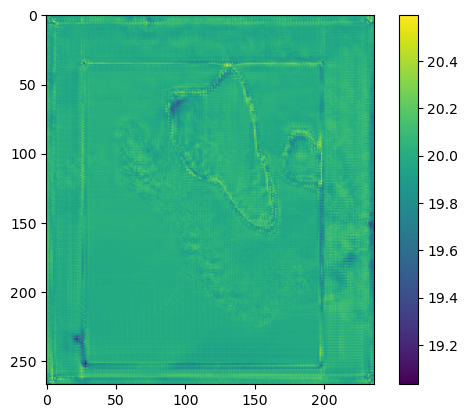

In [24]:
plt.imshow(predicted_conc[2])
plt.colorbar()
plt.show()

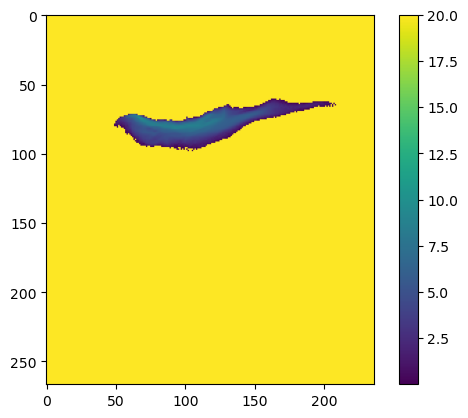

In [27]:
plt.imshow(testing_data[18, 0])
plt.colorbar()
plt.show()

In [25]:
input_stack = np.stack([
    testing_data[18, 0], # Initial conc field
    testing_data[18, 1], # xwind
    testing_data[18, 2], # ywind
    testing_data[18, 3], # abl
    testing_data[18, 4] # Pressure
], axis=0) 

# Convert to tensor (add batch dimension)
input_tensor = torch.from_numpy(input_stack[np.newaxis, ...]).float()

# Make prediction
with torch.no_grad():
    output_tensor = model(input_tensor)

# Get prediction and store in pre-allocated array
output_conc_field = output_tensor.numpy().squeeze()

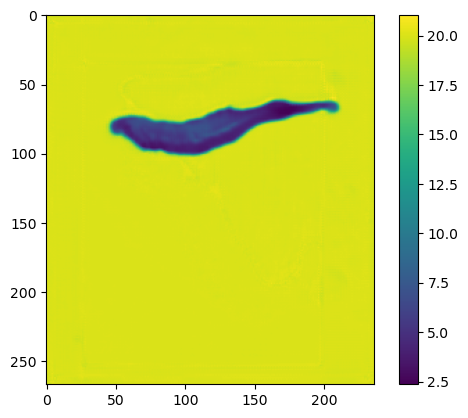

In [26]:
plt.imshow(output_conc_field)
plt.colorbar()
plt.show()